In [361]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.sparse as sp
from scipy.sparse.linalg import spsolve

"""
Create Your Own Plasma PIC Simulation (With Python)
Philip Mocz (2020) Princeton Univeristy, @PMocz

Simulate the 1D Two-Stream Instability
Code calculates the motions of electron under the Poisson-Maxwell equation
using the Particle-In-Cell (PIC) method

"""


def getAcc( pos, Nx, boxsize, n0, Gmtx, Lmtx ):
	"""
    Calculate the acceleration on each particle due to electric field
	pos      is an Nx1 matrix of particle positions
	Nx       is the number of mesh cells
	boxsize  is the domain [0,boxsize]
	n0       is the electron number density
	Gmtx     is an Nx x Nx matrix for calculating the gradient on the grid
	Lmtx     is an Nx x Nx matrix for calculating the laplacian on the grid
	a        is an Nx1 matrix of accelerations
	"""
	# Calculate Electron Number Density on the Mesh by 
	# placing particles into the 2 nearest bins (j & j+1, with proper weights)
	# and normalizing
	N          = pos.shape[0]
	dx         = boxsize / Nx
	j          = np.floor(pos/dx).astype(int)
	jp1        = j+1
	weight_j   = ( jp1*dx - pos  )/dx
	weight_jp1 = ( pos    - j*dx )/dx
	jp1        = np.mod(jp1, Nx)   # periodic BC
	n  = np.bincount(j[:,0],   weights=weight_j[:,0],   minlength=Nx);
	n += np.bincount(jp1[:,0], weights=weight_jp1[:,0], minlength=Nx);
	n *= n0 * boxsize / N / dx 
	
	# Solve Poisson's Equation: laplacian(phi) = n-n0
	phi_grid = spsolve(Lmtx, n-n0, permc_spec="MMD_AT_PLUS_A")
	
	# Apply Derivative to get the Electric field
	E_grid = - Gmtx @ phi_grid
	
	# Interpolate grid value onto particle locations
	E = weight_j * E_grid[j] + weight_jp1 * E_grid[jp1]
	
	a = -E

	return a
	


def main():
	""" Plasma PIC simulation """
	
	# Simulation parameters
	N         = 40000   # Number of particles
	Nx        = 400     # Number of mesh cells
	t         = 0       # current time of the simulation
	tEnd      = 200      # time at which simulation ends
	dt        = 1       # timestep
	boxsize   = 50      # periodic domain [0,boxsize]
	n0        = 1       # electron number density
	vb        = 3       # beam velocity
	vth       = 1       # beam width
	A         = 0.1     # perturbation
	plotRealTime = True # switch on for plotting as the simulation goes along
	
	# Generate Initial Conditions
	np.random.seed(42)            # set the random number generator seed
	# construct 2 opposite-moving Guassian beams
	pos  = np.random.rand(N,1) * boxsize  
	vel  = vth * np.random.randn(N,1) + vb
	Nh = int(N/2)
	vel[Nh:] *= -1
	# add perturbation
	vel *= (1 + A*np.sin(2*np.pi*pos/boxsize))
	
	# Construct matrix G to computer Gradient  (1st derivative)
	dx = boxsize/Nx
	e = np.ones(Nx)
	diags = np.array([-1,1])
	vals  = np.vstack((-e,e))
	Gmtx = sp.spdiags(vals, diags, Nx, Nx);
	Gmtx = sp.lil_matrix(Gmtx)
	Gmtx[0,Nx-1] = -1
	Gmtx[Nx-1,0] = 1
	Gmtx /= (2*dx)
	Gmtx = sp.csr_matrix(Gmtx)

	# Construct matrix L to computer Laplacian (2nd derivative)
	diags = np.array([-1,0,1])
	vals  = np.vstack((e,-2*e,e))
	Lmtx = sp.spdiags(vals, diags, Nx, Nx);
	Lmtx = sp.lil_matrix(Lmtx)
	Lmtx[0,Nx-1] = 1
	Lmtx[Nx-1,0] = 1
	Lmtx /= dx**2
	Lmtx = sp.csr_matrix(Lmtx)
	
	# calculate initial gravitational accelerations
	acc = getAcc( pos, Nx, boxsize, n0, Gmtx, Lmtx )
	
	# number of timesteps
	Nt = int(np.ceil(tEnd/dt))
	
	# prep figure
	fig = plt.figure(figsize=(5,4), dpi=80)
	
	# Simulation Main Loop
	for i in range(Nt):
		# (1/2) kick
		vel += acc * dt/2.0
		
		# drift (and apply periodic boundary conditions)
		pos += vel * dt
		pos = np.mod(pos, boxsize)
		
		# update accelerations
		acc = getAcc( pos, Nx, boxsize, n0, Gmtx, Lmtx )
		
		# (1/2) kick
		vel += acc * dt/2.0
		
		# update time
		t += dt
		%matplotlib
		# plot in real time - color 1/2 particles blue, other half red
		if plotRealTime or (i == Nt-1):
			plt.cla()
			plt.scatter(pos[0:Nh],vel[0:Nh],s=.4,color='blue', alpha=0.5)
			plt.scatter(pos[Nh:], vel[Nh:], s=.4,color='red',  alpha=0.5)
			plt.axis([0,boxsize,-6,6])
			
			plt.pause(0.001)
			
	
	# Save figure
	plt.xlabel('x')
	plt.ylabel('v')
	#plt.savefig('pic.png',dpi=240)
	plt.show()
	    
	return 0
	


if __name__== "__main__":
  main()

Using matplotlib backend: QtAgg
Using matplotlib backend: QtAgg
Using matplotlib backend: QtAgg
Using matplotlib backend: QtAgg
Using matplotlib backend: QtAgg
Using matplotlib backend: QtAgg
Using matplotlib backend: QtAgg
Using matplotlib backend: QtAgg
Using matplotlib backend: QtAgg
Using matplotlib backend: QtAgg
Using matplotlib backend: QtAgg
Using matplotlib backend: QtAgg
Using matplotlib backend: QtAgg
Using matplotlib backend: QtAgg
Using matplotlib backend: QtAgg
Using matplotlib backend: QtAgg
Using matplotlib backend: QtAgg
Using matplotlib backend: QtAgg
Using matplotlib backend: QtAgg
Using matplotlib backend: QtAgg
Using matplotlib backend: QtAgg
Using matplotlib backend: QtAgg
Using matplotlib backend: QtAgg
Using matplotlib backend: QtAgg
Using matplotlib backend: QtAgg
Using matplotlib backend: QtAgg
Using matplotlib backend: QtAgg
Using matplotlib backend: QtAgg
Using matplotlib backend: QtAgg
Using matplotlib backend: QtAgg
Using matplotlib backend: QtAgg
Using ma

In [13]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as st
from tqdm import tqdm


#function which calculates electric potential from charge density using FFT
def phi_compute(rho,eps0,Nx,Ny,dx,dy):
    kx = 2*np.pi*np.fft.fftfreq(Nx, d=dx)
    ky = 2*np.pi*np.fft.fftfreq(Ny, d=dy)
    
    #calculate fft of charge density
    rhok = np.fft.fft2(rho)
    phik = np.zeros((Nx,Ny), dtype = np.complex_)
    
    #calculate fourier transform of electric potential
    for i in range(Nx):
        for j in range(Ny):
            if kx[i] == 0 and ky[j] == 0:
                phik[i,j] = 0
            else:
                phik[i,j] = -rhok[i,j]/(kx[i]**2 + ky[j]**2)
                
    phik = 1 / eps0 * phik
    phi = np.real(np.fft.ifft2(phik))
    return phi

#function which interatively calculates electric potential from charge density using finite differencing
def phi_solve(f, rho, h, stepper, atol=1.E-6, max_steps=10**5):
    for _ in range(max_steps):
        f_new = stepper(f, rho, h)
        if np.max(np.abs(f_new - f)) < atol:
            return f_new
        f = f_new
    return f

#function which performs one finite difference step
def roll_step(f, rho, h):
    f_new = 0.25 * (np.roll(f, 1, axis = 0) + np.roll(f, -1, axis = 0) + np.roll(f, 1, axis = 1) + np.roll(f, -1, axis = 1)) - 0.25 * h**2 * rho
    return f_new
    
#function which calculates acceleration of each particle 
def getAccel(pos,Nx,Ny,Lx,Ly,dt,n0,N):
    eps0 = 1
    dx = Lx/Nx
    dy = Ly/Ny
    j = np.zeros((N,2))
    jp1 = np.zeros((N,2))
    
    #define grid points
    j[:,0] = np.floor(pos[:,0]/dx).astype(int)
    j[:,1] = np.floor(pos[:,1]/dy).astype(int)
    jp1 = j + 1
    
    #calculate weights of particle on each grid point
    weight_jxjy = (jp1[:,0]*dx - pos[:,0])/dx * (jp1[:,1]*dy - pos[:,1])/dy
    weight_jxp1jy = (pos[:,0] - j[:,0]*dx)/dx * (jp1[:,1]*dy - pos[:,1])/dy
    weight_jxjyp1 = (jp1[:,0]*dx - pos[:,0])/dx * (pos[:,1] - j[:,1]*dy)/dy
    weight_jxp1jyp1 = (pos[:,0] - j[:,0]*dx)/dx * (pos[:,1] - j[:,1]*dy)/dy
    
    #periodic boundary conditions:
    jp1[:,0] = np.mod(jp1[:,0], Nx)
    jp1[:,1] = np.mod(jp1[:,1], Ny)
    
    #smear the particle position across four nearest gridpoints, weighting by distance to each gridpoint 
    xbin = np.linspace(0, Nx, Nx+1)
    ybin = np.linspace(0, Ny, Ny+1)
    
    #count number of particles smeared to each grid point
    n = st.binned_statistic_2d(j[:,0], j[:,1], None, 'count', bins = [xbin,ybin], expand_binnumbers=True).statistic #(j,j) grid point
    n += st.binned_statistic_2d(jp1[:,0], jp1[:,1], None, 'count', bins = [xbin,ybin], expand_binnumbers=True).statistic #(j+1,j+1) grid point
    n += st.binned_statistic_2d(j[:,0], jp1[:,1], None, 'count', bins = [xbin,ybin], expand_binnumbers=True).statistic #(j,j+1) grid point
    n += st.binned_statistic_2d(jp1[:,0], j[:,1], None, 'count', bins = [xbin,ybin], expand_binnumbers=True).statistic #(j+1,j) grid point
    
    #weight the contribution  of each particle to each grid point it has been smeared across
    n[j[:,0].astype(int),j[:,1].astype(int)] *= weight_jxjy
    n[jp1[:,0].astype(int),j[:,1].astype(int)] *= weight_jxp1jy
    n[j[:,0].astype(int),jp1[:,1].astype(int)] *= weight_jxjyp1
    n[jp1[:,0].astype(int),jp1[:,1].astype(int)] *= weight_jxp1jyp1
    #n *= n0 * Lx*Ly / N /(dx*dy)
    rho = n0*n

    #calculate electric potential at each grid point
    phi_grid = phi_compute(rho,eps0,Nx,Ny,dx,dy)
    
    #calculate electric field from electric potential
    Ex = -np.gradient(phi_grid, dx, axis = 0)
    Ey = -np.gradient(phi_grid, dy, axis = 1)
    E = np.zeros((N,2))
    j = j.astype(int)
    jp1 = jp1.astype(int)
    
    #interpolate electric field at each particle position
    E[:,0] = Ex[j[:,0],j[:,1]]*weight_jxjy + Ex[j[:,0],jp1[:,1]]*weight_jxjyp1 + Ex[jp1[:,0],j[:,1]]*weight_jxp1jy + Ex[jp1[:,0],jp1[:,1]]*weight_jxp1jyp1
    E[:,1] = Ey[j[:,0],j[:,1]]*weight_jxjy + Ey[j[:,0],jp1[:,1]]*weight_jxjyp1 + Ey[jp1[:,0],j[:,1]]*weight_jxp1jy + Ey[jp1[:,0],jp1[:,1]]*weight_jxp1jyp1
    a = -E
    
    return a

    
    
    
    

In [31]:
def main():
    N = 4*10**4
    Nx = 128
    Ny = 128
    Lx = 10
    Ly = 10
    dx = Lx/Nx
    dy = Ly/Ny
    t = 0
    tEnd = 10
    dt = 0.1
    n0 = 100
    vb        = 1.5       # beam velocity
    vth       = 1       # beam width
    A         = 0.1     # perturbation
    plotRealTime = True # switch on for plotting as the simulation goes along
        
    pos = np.zeros((N,2))
    
    #initial positions of particles, organized which gaussian noise into two beams
    pos[:np.floor(N/2).astype(int),1] = np.mod(5*Ly/10 + 0.05 * np.random.randn(np.floor(N/2).astype(int)), Ly)
    pos[np.floor(N/2).astype(int):,1] = np.mod(5*Ly/10 + 0.05 * np.random.randn(np.floor(N/2).astype(int)), Ly)
    pos[:,0] = np.random.uniform(0,Lx, size = N)
    
    #initial velocity of each particle, organized with gaussian noise into two beams
    vel = np.zeros((N,2))
    vel[:np.floor(N/2).astype(int),0]  = vth * np.random.randn(np.floor(N/2).astype(int)) + 0.25*vb
    vel[np.floor(N/2).astype(int):,0]  = -vth * np.random.randn(np.floor(N/2).astype(int)) - vb

    vel[:,0] *= (1 + A*np.sin(2*np.pi*pos[:,0]/Lx))
    
    Nt = int(np.ceil(tEnd/dt))
    
    #calculate inital acceleration
    acc = getAccel(pos,Nx,Ny,Lx,Ly,dt,n0,N)
    
    #calculate new positions and velocities for each time step using leapfrog method
    for i in tqdm(range(Nt)):
        # (1/2) kick
        vel += acc * dt/2.0
        
        # drift (and apply periodic boundary conditions)
        pos += vel * dt
        pos[:,0] = np.mod(pos[:,0], Lx)
        pos[:,1] = np.mod(pos[:,1], Ly)


        # update accelerations
        acc = getAccel(pos,Nx,Ny,Lx,Ly,dt,n0,N)
        
        # (1/2) kick
        vel += acc * dt/2.0

        # update time
        t += dt
        
        %matplotlib
        # plot in real time - color 1/2 particles blue, other half red
        if plotRealTime or (i == Nt-1):
            plt.cla()
            #plt.scatter(pos[:np.floor(N/2).astype(int),0],pos[:np.floor(N/2).astype(int),1],s=.4,color='blue', alpha=0.5)
            #plt.scatter(pos[np.floor(N/2).astype(int):,0],pos[np.floor(N/2).astype(int):,1],s=.4,color='red', alpha=0.5)
            plt.scatter(pos[:np.floor(N/2).astype(int),0],vel[:np.floor(N/2).astype(int),0],s=.4,color='blue', alpha=0.5)
            plt.scatter(pos[np.floor(N/2).astype(int):,0],vel[np.floor(N/2).astype(int):,0],s=.4,color='red', alpha=0.5)
            plt.axis([0,Lx,-Ly,Ly])

            plt.pause(0.001)
            
    # Save figure
    plt.xlabel('x')
    plt.ylabel('y')
    #plt.savefig('pic.png',dpi=240)
    plt.show()
    
    return 0



In [30]:
if __name__== "__main__":
  main()

  0%|                                                                                          | 0/100 [00:00<?, ?it/s]

Using matplotlib backend: QtAgg


  2%|█▋                                                                                | 2/100 [00:00<00:45,  2.18it/s]

Using matplotlib backend: QtAgg


  3%|██▍                                                                               | 3/100 [00:01<00:42,  2.27it/s]

Using matplotlib backend: QtAgg


  4%|███▎                                                                              | 4/100 [00:01<00:42,  2.25it/s]

Using matplotlib backend: QtAgg


  5%|████                                                                              | 5/100 [00:02<00:41,  2.28it/s]

Using matplotlib backend: QtAgg


  6%|████▉                                                                             | 6/100 [00:02<00:40,  2.29it/s]

Using matplotlib backend: QtAgg


  7%|█████▋                                                                            | 7/100 [00:03<00:39,  2.33it/s]

Using matplotlib backend: QtAgg


  8%|██████▌                                                                           | 8/100 [00:03<00:39,  2.34it/s]

Using matplotlib backend: QtAgg


  9%|███████▍                                                                          | 9/100 [00:03<00:38,  2.37it/s]

Using matplotlib backend: QtAgg


 10%|████████                                                                         | 10/100 [00:04<00:37,  2.37it/s]

Using matplotlib backend: QtAgg


 11%|████████▉                                                                        | 11/100 [00:04<00:37,  2.36it/s]

Using matplotlib backend: QtAgg


 12%|█████████▋                                                                       | 12/100 [00:05<00:37,  2.32it/s]

Using matplotlib backend: QtAgg


 13%|██████████▌                                                                      | 13/100 [00:05<00:37,  2.34it/s]

Using matplotlib backend: QtAgg


 14%|███████████▎                                                                     | 14/100 [00:06<00:36,  2.35it/s]

Using matplotlib backend: QtAgg


 15%|████████████▏                                                                    | 15/100 [00:06<00:36,  2.34it/s]

Using matplotlib backend: QtAgg


 16%|████████████▉                                                                    | 16/100 [00:06<00:36,  2.31it/s]

Using matplotlib backend: QtAgg


 17%|█████████████▊                                                                   | 17/100 [00:07<00:36,  2.30it/s]

Using matplotlib backend: QtAgg


 18%|██████████████▌                                                                  | 18/100 [00:07<00:35,  2.31it/s]

Using matplotlib backend: QtAgg


 19%|███████████████▍                                                                 | 19/100 [00:08<00:34,  2.34it/s]

Using matplotlib backend: QtAgg


 20%|████████████████▏                                                                | 20/100 [00:08<00:33,  2.38it/s]

Using matplotlib backend: QtAgg


 21%|█████████████████                                                                | 21/100 [00:09<00:33,  2.39it/s]

Using matplotlib backend: QtAgg


 22%|█████████████████▊                                                               | 22/100 [00:09<00:32,  2.37it/s]

Using matplotlib backend: QtAgg


 23%|██████████████████▋                                                              | 23/100 [00:09<00:32,  2.39it/s]

Using matplotlib backend: QtAgg


 24%|███████████████████▍                                                             | 24/100 [00:10<00:31,  2.40it/s]

Using matplotlib backend: QtAgg


 25%|████████████████████▎                                                            | 25/100 [00:10<00:31,  2.40it/s]

Using matplotlib backend: QtAgg


 26%|█████████████████████                                                            | 26/100 [00:11<00:30,  2.41it/s]

Using matplotlib backend: QtAgg


 27%|█████████████████████▊                                                           | 27/100 [00:11<00:30,  2.41it/s]

Using matplotlib backend: QtAgg
Using matplotlib backend: QtAgg


 29%|███████████████████████▍                                                         | 29/100 [00:12<00:31,  2.29it/s]

Using matplotlib backend: QtAgg


 30%|████████████████████████▎                                                        | 30/100 [00:12<00:30,  2.33it/s]

Using matplotlib backend: QtAgg


 31%|█████████████████████████                                                        | 31/100 [00:13<00:29,  2.36it/s]

Using matplotlib backend: QtAgg


 32%|█████████████████████████▉                                                       | 32/100 [00:13<00:28,  2.39it/s]

Using matplotlib backend: QtAgg


 33%|██████████████████████████▋                                                      | 33/100 [00:14<00:28,  2.36it/s]

Using matplotlib backend: QtAgg


 34%|███████████████████████████▌                                                     | 34/100 [00:14<00:27,  2.38it/s]

Using matplotlib backend: QtAgg


 35%|████████████████████████████▎                                                    | 35/100 [00:14<00:26,  2.41it/s]

Using matplotlib backend: QtAgg


 36%|█████████████████████████████▏                                                   | 36/100 [00:15<00:26,  2.39it/s]

Using matplotlib backend: QtAgg


 37%|█████████████████████████████▉                                                   | 37/100 [00:15<00:25,  2.42it/s]

Using matplotlib backend: QtAgg


 38%|██████████████████████████████▊                                                  | 38/100 [00:16<00:25,  2.43it/s]

Using matplotlib backend: QtAgg


 39%|███████████████████████████████▌                                                 | 39/100 [00:16<00:25,  2.42it/s]

Using matplotlib backend: QtAgg


 40%|████████████████████████████████▍                                                | 40/100 [00:16<00:24,  2.44it/s]

Using matplotlib backend: QtAgg


 41%|█████████████████████████████████▏                                               | 41/100 [00:17<00:24,  2.45it/s]

Using matplotlib backend: QtAgg


 42%|██████████████████████████████████                                               | 42/100 [00:17<00:23,  2.44it/s]

Using matplotlib backend: QtAgg


 43%|██████████████████████████████████▊                                              | 43/100 [00:18<00:23,  2.43it/s]

Using matplotlib backend: QtAgg


 44%|███████████████████████████████████▋                                             | 44/100 [00:18<00:22,  2.44it/s]

Using matplotlib backend: QtAgg


 45%|████████████████████████████████████▍                                            | 45/100 [00:19<00:22,  2.45it/s]

Using matplotlib backend: QtAgg


 46%|█████████████████████████████████████▎                                           | 46/100 [00:19<00:22,  2.45it/s]

Using matplotlib backend: QtAgg


 47%|██████████████████████████████████████                                           | 47/100 [00:19<00:21,  2.46it/s]

Using matplotlib backend: QtAgg


 48%|██████████████████████████████████████▉                                          | 48/100 [00:20<00:21,  2.46it/s]

Using matplotlib backend: QtAgg


 49%|███████████████████████████████████████▋                                         | 49/100 [00:20<00:20,  2.47it/s]

Using matplotlib backend: QtAgg


 50%|████████████████████████████████████████▌                                        | 50/100 [00:21<00:20,  2.43it/s]

Using matplotlib backend: QtAgg


 51%|█████████████████████████████████████████▎                                       | 51/100 [00:21<00:20,  2.44it/s]

Using matplotlib backend: QtAgg


 52%|██████████████████████████████████████████                                       | 52/100 [00:21<00:19,  2.45it/s]

Using matplotlib backend: QtAgg


 53%|██████████████████████████████████████████▉                                      | 53/100 [00:22<00:19,  2.45it/s]

Using matplotlib backend: QtAgg


 54%|███████████████████████████████████████████▋                                     | 54/100 [00:22<00:18,  2.46it/s]

Using matplotlib backend: QtAgg


 55%|████████████████████████████████████████████▌                                    | 55/100 [00:23<00:18,  2.47it/s]

Using matplotlib backend: QtAgg


 56%|█████████████████████████████████████████████▎                                   | 56/100 [00:23<00:17,  2.47it/s]

Using matplotlib backend: QtAgg


 57%|██████████████████████████████████████████████▏                                  | 57/100 [00:23<00:17,  2.44it/s]

Using matplotlib backend: QtAgg


 58%|██████████████████████████████████████████████▉                                  | 58/100 [00:24<00:17,  2.45it/s]

Using matplotlib backend: QtAgg


 59%|███████████████████████████████████████████████▊                                 | 59/100 [00:24<00:16,  2.44it/s]

Using matplotlib backend: QtAgg


 60%|████████████████████████████████████████████████▌                                | 60/100 [00:25<00:16,  2.39it/s]

Using matplotlib backend: QtAgg


 61%|█████████████████████████████████████████████████▍                               | 61/100 [00:25<00:16,  2.40it/s]

Using matplotlib backend: QtAgg


 62%|██████████████████████████████████████████████████▏                              | 62/100 [00:26<00:16,  2.37it/s]

Using matplotlib backend: QtAgg


 63%|███████████████████████████████████████████████████                              | 63/100 [00:26<00:15,  2.40it/s]

Using matplotlib backend: QtAgg


 64%|███████████████████████████████████████████████████▊                             | 64/100 [00:26<00:15,  2.37it/s]

Using matplotlib backend: QtAgg


 65%|████████████████████████████████████████████████████▋                            | 65/100 [00:27<00:14,  2.40it/s]

Using matplotlib backend: QtAgg


 66%|█████████████████████████████████████████████████████▍                           | 66/100 [00:27<00:14,  2.43it/s]

Using matplotlib backend: QtAgg


 67%|██████████████████████████████████████████████████████▎                          | 67/100 [00:28<00:13,  2.41it/s]

Using matplotlib backend: QtAgg


 68%|███████████████████████████████████████████████████████                          | 68/100 [00:28<00:13,  2.42it/s]

Using matplotlib backend: QtAgg


 69%|███████████████████████████████████████████████████████▉                         | 69/100 [00:28<00:12,  2.44it/s]

Using matplotlib backend: QtAgg


 70%|████████████████████████████████████████████████████████▋                        | 70/100 [00:29<00:12,  2.45it/s]

Using matplotlib backend: QtAgg


 71%|█████████████████████████████████████████████████████████▌                       | 71/100 [00:29<00:11,  2.44it/s]

Using matplotlib backend: QtAgg


 72%|██████████████████████████████████████████████████████████▎                      | 72/100 [00:30<00:11,  2.45it/s]

Using matplotlib backend: QtAgg


 73%|███████████████████████████████████████████████████████████▏                     | 73/100 [00:30<00:11,  2.45it/s]

Using matplotlib backend: QtAgg


 74%|███████████████████████████████████████████████████████████▉                     | 74/100 [00:30<00:10,  2.45it/s]

Using matplotlib backend: QtAgg


 75%|████████████████████████████████████████████████████████████▊                    | 75/100 [00:31<00:10,  2.41it/s]

Using matplotlib backend: QtAgg


 76%|█████████████████████████████████████████████████████████████▌                   | 76/100 [00:31<00:10,  2.40it/s]

Using matplotlib backend: QtAgg


 77%|██████████████████████████████████████████████████████████████▎                  | 77/100 [00:32<00:09,  2.39it/s]

Using matplotlib backend: QtAgg


 78%|███████████████████████████████████████████████████████████████▏                 | 78/100 [00:32<00:09,  2.39it/s]

Using matplotlib backend: QtAgg


 79%|███████████████████████████████████████████████████████████████▉                 | 79/100 [00:33<00:08,  2.35it/s]

Using matplotlib backend: QtAgg


 80%|████████████████████████████████████████████████████████████████▊                | 80/100 [00:33<00:08,  2.37it/s]

Using matplotlib backend: QtAgg


 81%|█████████████████████████████████████████████████████████████████▌               | 81/100 [00:33<00:07,  2.38it/s]

Using matplotlib backend: QtAgg


 82%|██████████████████████████████████████████████████████████████████▍              | 82/100 [00:34<00:07,  2.39it/s]

Using matplotlib backend: QtAgg


 83%|███████████████████████████████████████████████████████████████████▏             | 83/100 [00:34<00:07,  2.41it/s]

Using matplotlib backend: QtAgg


 84%|████████████████████████████████████████████████████████████████████             | 84/100 [00:35<00:06,  2.40it/s]

Using matplotlib backend: QtAgg


 85%|████████████████████████████████████████████████████████████████████▊            | 85/100 [00:35<00:06,  2.39it/s]

Using matplotlib backend: QtAgg


 86%|█████████████████████████████████████████████████████████████████████▋           | 86/100 [00:35<00:05,  2.37it/s]

Using matplotlib backend: QtAgg


 87%|██████████████████████████████████████████████████████████████████████▍          | 87/100 [00:36<00:05,  2.37it/s]

Using matplotlib backend: QtAgg


 88%|███████████████████████████████████████████████████████████████████████▎         | 88/100 [00:36<00:05,  2.38it/s]

Using matplotlib backend: QtAgg


 89%|████████████████████████████████████████████████████████████████████████         | 89/100 [00:37<00:04,  2.36it/s]

Using matplotlib backend: QtAgg


 90%|████████████████████████████████████████████████████████████████████████▉        | 90/100 [00:37<00:04,  2.37it/s]

Using matplotlib backend: QtAgg


 91%|█████████████████████████████████████████████████████████████████████████▋       | 91/100 [00:38<00:03,  2.38it/s]

Using matplotlib backend: QtAgg


 92%|██████████████████████████████████████████████████████████████████████████▌      | 92/100 [00:38<00:03,  2.36it/s]

Using matplotlib backend: QtAgg


 93%|███████████████████████████████████████████████████████████████████████████▎     | 93/100 [00:38<00:02,  2.39it/s]

Using matplotlib backend: QtAgg


 94%|████████████████████████████████████████████████████████████████████████████▏    | 94/100 [00:39<00:02,  2.38it/s]

Using matplotlib backend: QtAgg


 95%|████████████████████████████████████████████████████████████████████████████▉    | 95/100 [00:39<00:02,  2.38it/s]

Using matplotlib backend: QtAgg


 96%|█████████████████████████████████████████████████████████████████████████████▊   | 96/100 [00:40<00:01,  2.32it/s]

Using matplotlib backend: QtAgg


 97%|██████████████████████████████████████████████████████████████████████████████▌  | 97/100 [00:40<00:01,  2.37it/s]

Using matplotlib backend: QtAgg


 98%|███████████████████████████████████████████████████████████████████████████████▍ | 98/100 [00:41<00:00,  2.27it/s]

Using matplotlib backend: QtAgg


 99%|████████████████████████████████████████████████████████████████████████████████▏| 99/100 [00:41<00:00,  2.29it/s]

Using matplotlib backend: QtAgg


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:41<00:00,  2.38it/s]

Using matplotlib backend: QtAgg


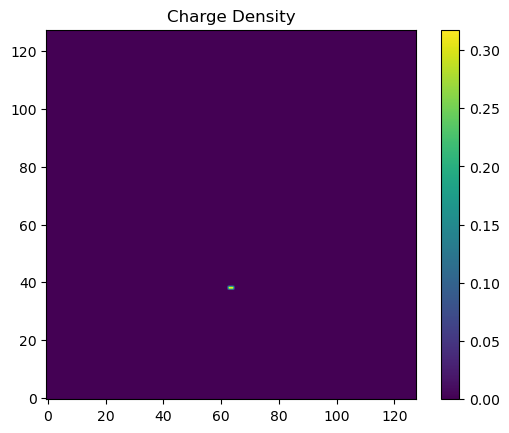

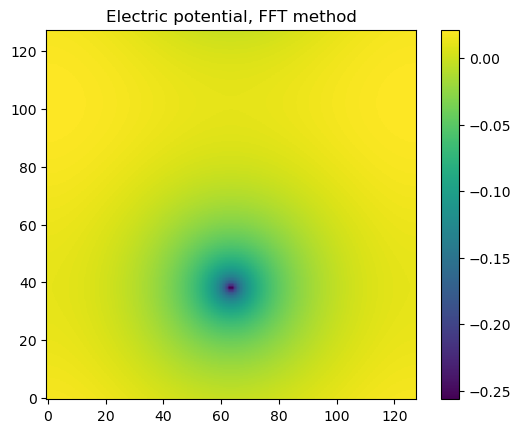

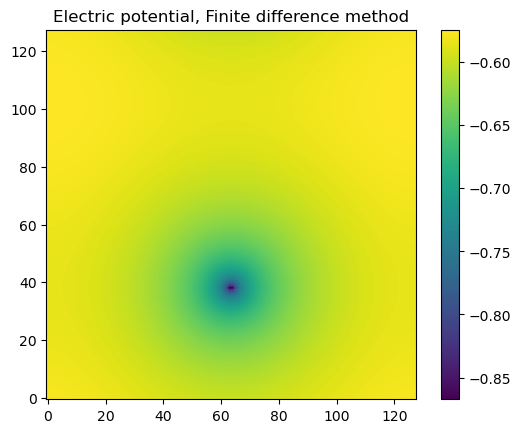

In [27]:
Nx = 128
Ny = 128
Lx = 10**2
Ly = 10**2
N = 10**2
q = 1
m = 1
eps0 = 1
dx = Lx/Nx
dy = Ly/Ny
rho = np.zeros((Nx,Ny))
x = np.linspace(0, Lx, Nx)
y = np.linspace(0, Ly, Ny)
t = 0.05

def gaussian2d(Nx, Ny, x, y, t):
    g = np.zeros((Nx,Ny))
    for i in range(Nx):
        for j in range(Ny):
            g[i,j] = np.exp(-((x[i]-30)**2 + (y[j]-50)**2)/(2*t)) / (4*np.pi*t)
    return g

rho2d = gaussian2d(Nx, Ny, x , y, t)
phitest2d=phi_compute(rho2d,eps0,Nx,Ny,dx,dy)

f = np.zeros((Nx,Ny))
gauss2d_solve = phi_solve(f, rho2d, dx, roll_step, atol=1.E-6, max_steps=10**5)

plt.imshow(rho2d, origin = 'lower')
plt.title('Charge Density')
plt.colorbar()
plt.show()

plt.imshow(phitest2d, origin = 'lower')
plt.title('Electric potential, FFT method')
plt.colorbar()
plt.show()

plt.imshow(gauss2d_solve, origin = 'lower')
plt.title('Electric potential, Finite difference method')
plt.colorbar()
plt.show()